# Extreme Value Distributions for Groundwater Levels

Fit Generalized Extreme Value (GEV) distribution to annual maximum values.

### 0. Load libraries, data and run previously developed code

> Install dependences if needed (uncomment pip install, if required)

In [1]:
# %pip install --upgrade pandas numpy scipy statsmodels matplotlib datetime
%matplotlib inline

Import necessary libraries (include more if needed).

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib
import datetime
import wget

### 1. Read and process the data

## Read the dataset

In [3]:
data = pd.read_csv("B39D0321001_meetreeks.csv", sep = ';')
# data = pd.read_csv("B40C3303001_meetreeks.csv", sep = ';')
# data_name = wget.download('https://surfdrive.surf.nl/files/index.php/s/2Z1OHYg5Gv9PIAK/download')
# data = pd.read_csv(data_name, sep = ';')
data.head()

,date,GW level [cm+MSL]
0,1954 12 14,325
1,1954 12 28,343
2,1955 01 15,320
3,1955 01 28,347
4,1955 02 14,344


## Process and plot the timeseries

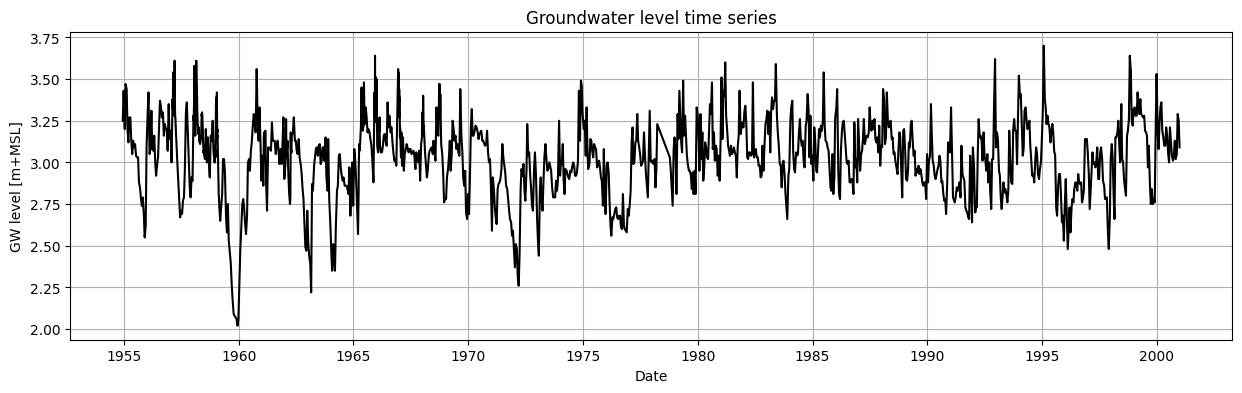

In [4]:
data['date'] = pd.to_datetime(data['date'])

data['GW level [m+MSL]'] = data['GW level [cm+MSL]'] / 100  # convert vrom cm to m
data['GW level [m+MSL]'].dropna

data.set_axis([np.linspace(0, len(data)-1, len(data), dtype=int)], axis='index')
fig, axs=plt.subplots(1, 1)
axs.plot(data['date'], data['GW level [m+MSL]'], 'k', label='${Time series}$')
axs.set_title('Groundwater level time series')
axs.set_xlabel('Date')
axs.set_ylabel('GW level [m+MSL]')
fig.set_size_inches(15, 4)
axs.grid()

## Extract annual maxima

In [5]:
def yearly_maxima(data):
    idx_max = data.groupby(pd.DatetimeIndex(data['date']).year)['GW level [m+MSL]'].idxmax()
    max_list = data.loc[idx_max]
    return max_list

yearly_maxima_list = yearly_maxima(data)
# yearly_maxima_list

## Plot time series including annual maxima 

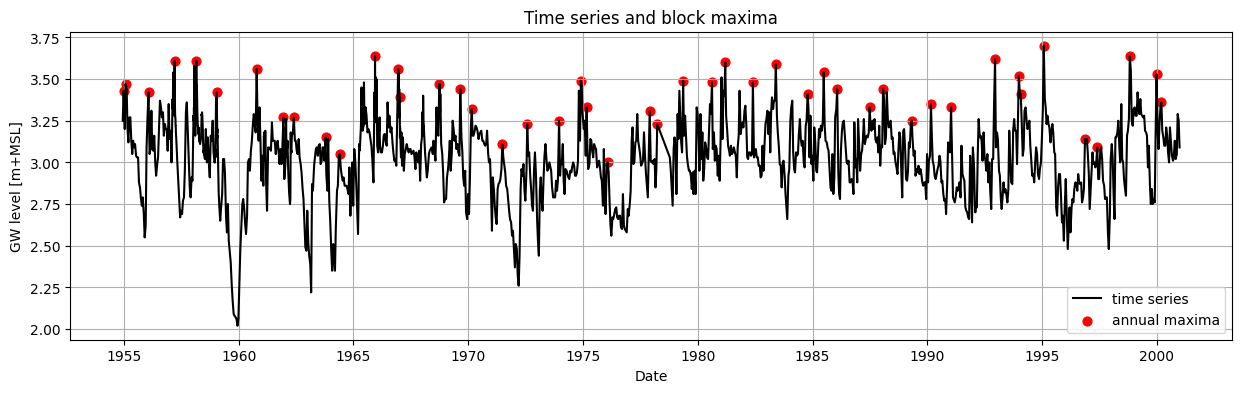

In [8]:
fig, axs = plt.subplots(1, 1)
axs.plot(data['date'], data['GW level [m+MSL]'], 'k', label='time series')
axs.scatter(yearly_maxima_list['date'], yearly_maxima_list['GW level [m+MSL]'], 40, 'r', label = 'annual maxima')
axs.set_title('Time series and block maxima')
axs.set_xlabel('Date')
axs.set_ylabel('GW level [m+MSL]')
fig.set_size_inches(15, 4)
axs.grid()
axs.legend()

### 2. Calculate the empirical distribution function

## Calculate the ECDF

*Steps*:
- Sort the observations of the variable
- Calculate the length (size) of your observations, *n*
- Assign non-exceedance probabilities to each observation, *p=i/(n+1)*, where *i* is the rank
- Store the probabilities and sorted observations in a DataFrame using: 

`ecdf = pd.DataFrame({'F_x':p_data, 'Hs(m)':sorted_data})`

where p_data are the probabilities and sorted_data your sorted observations.

In [9]:
def calculate_ecdf(data):
    sorted_data = np.sort(data) 
    n_data = sorted_data.size 
    p_data = np.arange(1, n_data+1) / (n_data +1)
    ecdf = pd.DataFrame({'F_x':p_data, 'GW level [m+MSL]':sorted_data})
    return ecdf

Apply the ECDF function to the extremes sampled using annual maxima.

In [10]:
ecdf = calculate_ecdf(yearly_maxima_list['GW level [m+MSL]'])
# ecdf.head()

## Plot the ECDF

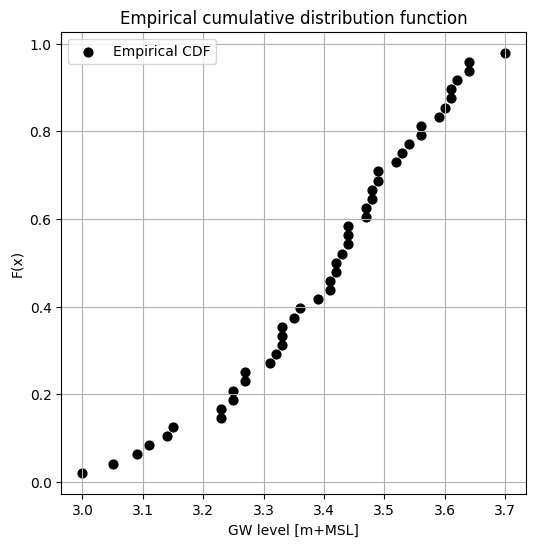

In [11]:
fig, axs = plt.subplots(1, 1)
axs.scatter(ecdf['GW level [m+MSL]'], ecdf['F_x'], 40, 'k', label = 'Empirical CDF')
axs.set_title('Empirical cumulative distribution function')
axs.set_ylabel('F(x)')
axs.set_xlabel('GW level [m+MSL]')
fig.set_size_inches(6, 6)
axs.grid()
axs.legend()

## 3. Fit extreme value distributions

### Fit Gumbel distribution (for maxima, right-skewed) to the extreme observations obtained with annual maxima

In [12]:
Gumbel_par = stats.gumbel_r.fit(yearly_maxima_list['GW level [m+MSL]'], method = 'mle')
# Print the estimated parameters
print(f"Gumbel location parameter: {Gumbel_par[0]}")
print(f"Gumbel scale parameter: {Gumbel_par[1]}")

Gumbel location parameter: 3.3120667477418806
Gumbel scale parameter: 0.1749757339270525


### Fit GEV distribution to the extreme observations obtained with annual maxima

In [13]:
GEV_par = stats.genextreme.fit(yearly_maxima_list['GW level [m+MSL]'], method = 'mle')
# Print the estimated parameters
print(f"GEV shape parameter: {GEV_par[0]}")
print(f"GEV location parameter: {GEV_par[1]}")
print(f"GEV scale parameter: {GEV_par[2]}")

GEV shape parameter: 0.4869328932216869
GEV location parameter: 3.3569809388767133
GEV scale parameter: 0.18104924257164604


**Plot the fit**

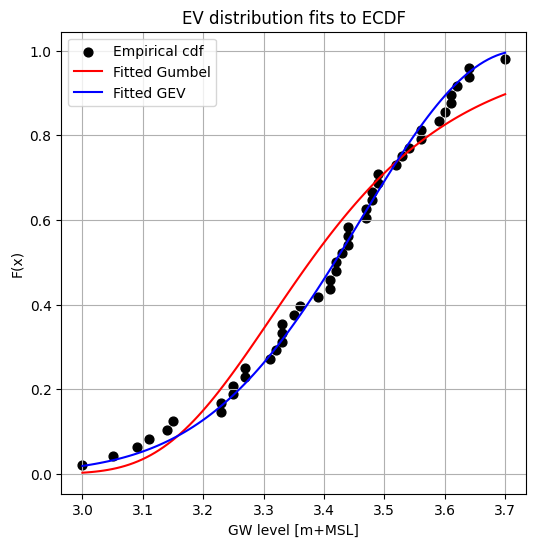

In [14]:
H = np.linspace(min(yearly_maxima_list['GW level [m+MSL]']), max(yearly_maxima_list['GW level [m+MSL]']),100)
Gumbel_p = stats.gumbel_r.cdf(H, Gumbel_par[0], Gumbel_par[1])
GEV_p = stats.genextreme.cdf(H, GEV_par[0], GEV_par[1], GEV_par[2])

fig, axs = plt.subplots(1, 1)
axs.scatter(ecdf['GW level [m+MSL]'], ecdf['F_x'], 40, 'k', label = 'Empirical cdf')
axs.plot(H, Gumbel_p, 'r', label = 'Fitted Gumbel')
axs.plot(H, GEV_p, 'b', label = 'Fitted GEV')
axs.set_title('EV distribution fits to ECDF')
axs.set_ylabel('F(x)')
axs.set_xlabel('GW level [m+MSL]')
fig.set_size_inches(6, 6)
axs.grid()
axs.legend()

## 4. Goodness-of-fit

### Kolmogorov-Smirnov hypothesis test

**Calculate the p-value obtained from the Kolmogorov-Smirnov test to assess the goodness of fit**

In [96]:
stats.kstest(ecdf['GW level [m+MSL]'], stats.gumbel_r.ppf(ecdf['F_x'], Gumbel_par[0], Gumbel_par[1]))

KstestResult(statistic=0.14893617021276595, pvalue=0.6800174807197423, statistic_location=3.4087849596688296, statistic_sign=-1)

### Gumbel probability plot

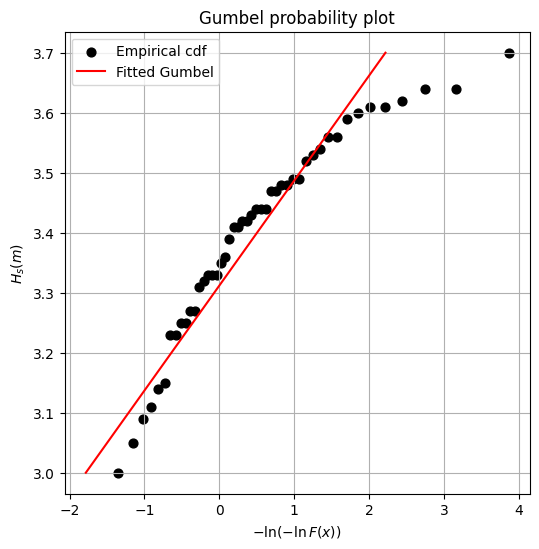

In [97]:
obs_prob_plot_x = -np.log(-np.log(ecdf['F_x']))
obs_prob_plot_y = ecdf['GW level [m+MSL]']

theor_prob_plot_x = -np.log(-np.log(Gumbel_p))
theor_prob_plot_y = H

fig, axs = plt.subplots(1, 1)
axs.scatter(obs_prob_plot_x, obs_prob_plot_y, 40, 'k', label = 'Empirical cdf')
axs.plot(theor_prob_plot_x, theor_prob_plot_y, 'r', label = 'Fitted Gumbel')
axs.set_title('Gumbel probability plot')
axs.set_xlabel('$-\ln(-\ln F(x))$')
axs.set_ylabel('${H_s (m)}$')
fig.set_size_inches(6, 6)
axs.grid()
axs.legend()

## 5. Statistics

<figure>
  <IMG SRC="C:\Users\swd\OneDrive - Stichting Deltares\Scripts and code\Extreme Value Analysis (Jupyter)\Tabel_EN_water_values.png" WIDTH=300 ALIGN="left">
</figure>

### 5.1 Gumbel fit

In [16]:
GW_perma_Gumbel = data['GW level [m+MSL]'].quantile(.5)  # CAREFUL, ONLY FOR EVENLY SPACED REASINGS IN TIME 
print('Quasi-permanent (fraction of time exceeded = 50%) ', GW_perma_Gumbel) 
GW_freq_Gumbel = data['GW level [m+MSL]'].quantile(.9)  # CAREFUL, ONLY FOR EVENLY SPACED REASINGS IN TIME
print('Frequent (fraction of time exceeded = 10%) ', GW_freq_Gumbel)   
GW_comb_T10_Gumbel = stats.gumbel_r.ppf(1-1/10, Gumbel_par[0], Gumbel_par[1])
print('Comnination (return period 10 years) ', GW_comb_T10_Gumbel)
GW_char_T50_Gumbel = stats.gumbel_r.ppf(1-1/50, Gumbel_par[0], Gumbel_par[1])
print('Characteristic (return period 50 years) ', GW_char_T50_Gumbel)
GW_acc_T1000_Gumbel = stats.gumbel_r.ppf(1-1/1000, Gumbel_par[0], Gumbel_par[1])
print('Accidental (return period 1000 years) ', GW_acc_T1000_Gumbel)

Quasi-permanent (fraction of time exceeded = 50%)  3.08
Frequent (fraction of time exceeded = 10%)  3.34
Comnination (return period 10 years)  3.7058264224438355
Characteristic (return period 50 years)  3.9948113281525415
Accidental (return period 1000 years)  4.520668773128122


#### Plot all statistics (Gumbel)

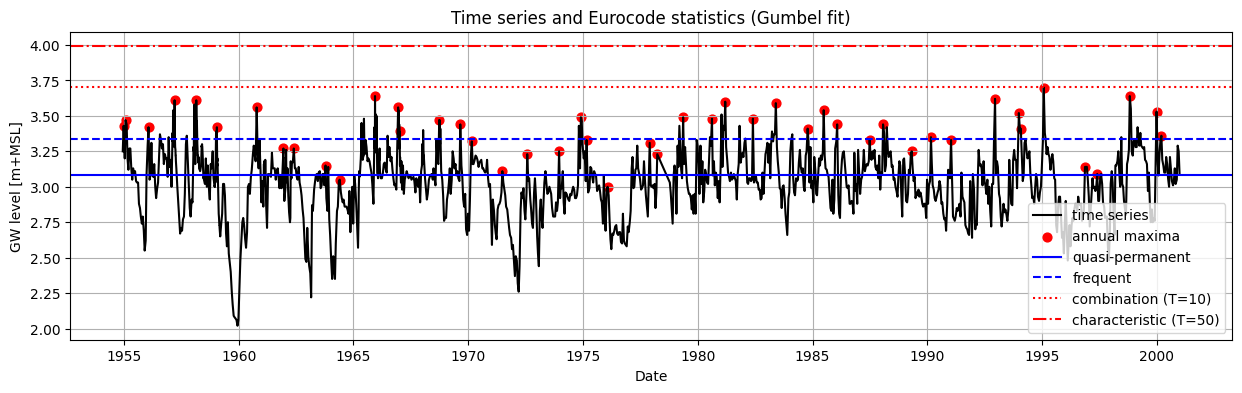

In [18]:
fig, axs = plt.subplots(1, 1)
axs.plot(data['date'], data['GW level [m+MSL]'], 'k', label='time series')
axs.scatter(yearly_maxima_list['date'], yearly_maxima_list['GW level [m+MSL]'], 40, 'r', label = 'annual maxima')
axs.axhline(y = GW_perma_Gumbel, color = 'b', linestyle = '-', label = 'quasi-permanent')
axs.axhline(y = GW_freq_Gumbel, color = 'b', linestyle = '--', label = 'frequent')
axs.axhline(y = GW_comb_T10_Gumbel, color = 'r', linestyle = ':', label = 'combination (T=10)')
axs.axhline(y = GW_char_T50_Gumbel, color = 'r', linestyle = '-.', label = 'characteristic (T=50)')
# axs.axhline(y = GW_acc_T1000_Gumbel, color = 'r', linestyle = '-', label = 'accidental (T=1000)')
axs.set_title('Time series and Eurocode statistics (Gumbel fit)')
axs.set_xlabel('Date')
axs.set_ylabel('GW level [m+MSL]')
fig.set_size_inches(15, 4)
axs.grid()
axs.legend(loc='lower right')

### 5.1 GEV fit

In [19]:
GW_perma_GEV = data['GW level [m+MSL]'].quantile(.5)  # CAREFUL, ONLY FOR EVENLY SPACED REASINGS IN TIME 
print('Quasi-permanent (fraction of time exceeded = 50%) ', GW_perma_GEV) 
GW_freq_GEV = data['GW level [m+MSL]'].quantile(.9)  # CAREFUL, ONLY FOR EVENLY SPACED REASINGS IN TIME
print('Frequent (fraction of time exceeded = 10%) ', GW_freq_GEV)   
GW_comb_T10_GEV = stats.genextreme.ppf(1-1/10, GEV_par[0], GEV_par[1], GEV_par[2])
print('Comnination (return period 10 years) ', GW_comb_T10_GEV)
GW_char_T50_GEV = stats.genextreme.ppf(1-1/50, GEV_par[0], GEV_par[1], GEV_par[2])
print('Characteristic (return period 50 years) ', GW_char_T50_GEV)
GW_acc_T1000_GEV = stats.genextreme.ppf(1-1/1000, GEV_par[0], GEV_par[1], GEV_par[2])
print('Accidental (return period 1000 years) ', GW_acc_T1000_GEV)

Quasi-permanent (fraction of time exceeded = 50%)  3.08
Frequent (fraction of time exceeded = 10%)  3.34
Comnination (return period 10 years)  3.604506209472268
Characteristic (return period 50 years)  3.673183601789503
Accidental (return period 1000 years)  3.715924867977917


#### Plot all statistics (GEV)

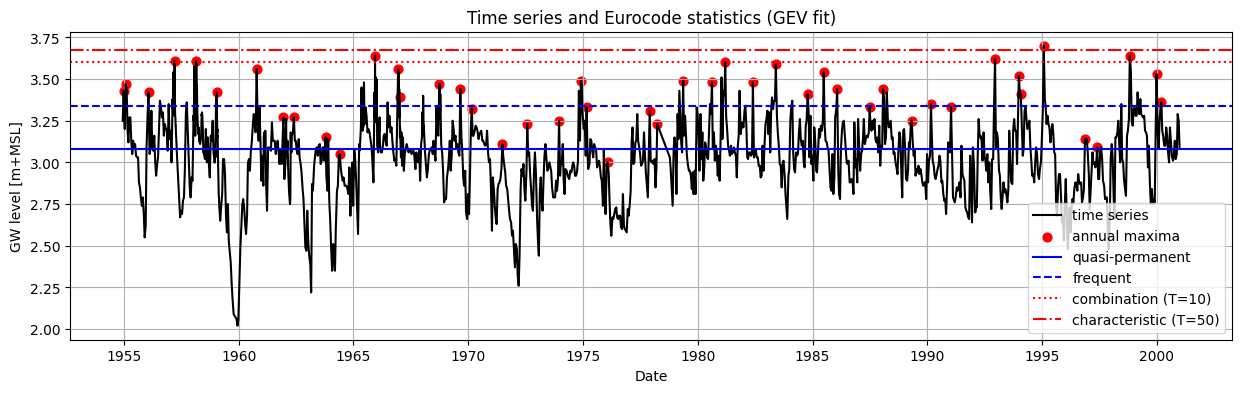

In [20]:
fig, axs = plt.subplots(1, 1)
axs.plot(data['date'], data['GW level [m+MSL]'], 'k', label='time series')
axs.scatter(yearly_maxima_list['date'], yearly_maxima_list['GW level [m+MSL]'], 40, 'r', label = 'annual maxima')
axs.axhline(y = GW_perma_GEV, color = 'b', linestyle = '-', label = 'quasi-permanent')
axs.axhline(y = GW_freq_GEV, color = 'b', linestyle = '--', label = 'frequent')
axs.axhline(y = GW_comb_T10_GEV, color = 'r', linestyle = ':', label = 'combination (T=10)')
axs.axhline(y = GW_char_T50_GEV, color = 'r', linestyle = '-.', label = 'characteristic (T=50)')
# axs.axhline(y = GW_acc_T1000_GEV, color = 'r', linestyle = '-', label = 'accidental (T=1000)')
axs.set_title('Time series and Eurocode statistics (GEV fit)')
axs.set_xlabel('Date')
axs.set_ylabel('GW level [m+MSL]')
fig.set_size_inches(15, 4)
axs.grid()
axs.legend()

#### Plot PDF comparison

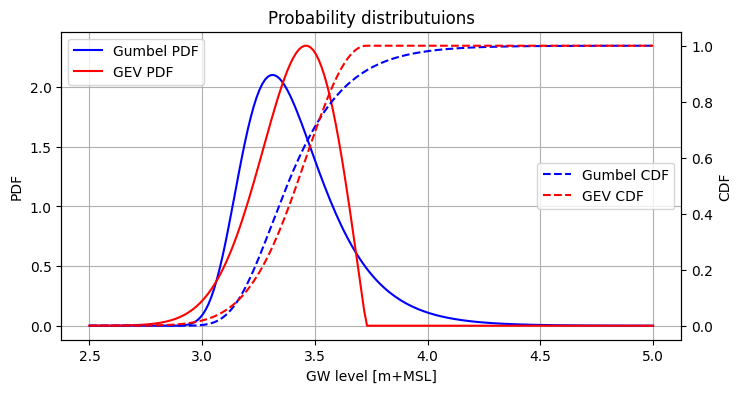

In [134]:
x = np.linspace(2.5, 5, 200)
fig, axs1 = plt.subplots(1, 1)
axs1.plot(x, stats.gumbel_r.pdf(x, Gumbel_par[0], Gumbel_par[1]), 'b', linestyle = '-', label='Gumbel PDF')
axs1.plot(x, stats.genextreme.pdf(x, GEV_par[0], GEV_par[1], GEV_par[2]), 'r', linestyle = '-', label='GEV PDF')
axs2 = axs1.twinx()
axs2.plot(x, stats.gumbel_r.cdf(x, Gumbel_par[0], Gumbel_par[1]), 'b', linestyle = '--', label='Gumbel CDF')
axs2.plot(x, stats.genextreme.cdf(x, GEV_par[0], GEV_par[1], GEV_par[2]), 'r', linestyle = '--', label='GEV CDF')
axs1.set_title('Probability distributuions')
axs1.set_xlabel('GW level [m+MSL]')
axs1.set_ylabel('PDF')
axs2.set_ylabel('CDF')
fig.set_size_inches(8, 4)
axs1.grid()
axs1.legend(loc='upper left')
axs2.legend(loc='center right')